In [2]:
## from: http://stackoverflow.com/questions/17558096/animated-title-in-matplotlib

def _blit_draw(self, artists, bg_cache):
    # Handles blitted drawing, which renders only the artists given instead
    # of the entire figure.
    updated_ax = []
    for a in artists:
        # If we haven't cached the background for this axes object, do
        # so now. This might not always be reliable, but it's an attempt
        # to automate the process.
        if a.axes not in bg_cache:
            # bg_cache[a.axes] = a.figure.canvas.copy_from_bbox(a.axes.bbox)
            # change here
            bg_cache[a.axes] = a.figure.canvas.copy_from_bbox(a.axes.figure.bbox)
        a.axes.draw_artist(a)
        updated_ax.append(a.axes)

    # After rendering all the needed artists, blit each axes individually.
    for ax in set(updated_ax):
        # and here
        # ax.figure.canvas.blit(ax.bbox)
        ax.figure.canvas.blit(ax.figure.bbox)

In [3]:
def biomass2LAI(x,sla,leaf_stem):
    '''
    Convert biomass to lai based on the specific leaf area.
    
    x: array of biomass values in g/m2
    sla: specific leaf area m2/kg c
    leaf_stem: ratio of leaf mass to stem mass
    '''
    x /= 1000. # g/m2 > kg/m2
    leaf = (x*leaf_stem) / (1.+leaf_stem) # compute leaf wet biomass
    lai = leaf * sla # convert leaf dry biomass to leaf area

    return lai

In [4]:
import gdal
import glob
from mpl_toolkits.basemap import Basemap
import matplotlib
import matplotlib.animation as animation
from IPython.display import clear_output

shp = '/Volumes/data/como_watershed_wgs84.shp'

def coord2dd(d,m,s): return d+(m/60.)+(s/60.)

In [5]:
# MONKEY PATCH!!
matplotlib.animation.Animation._blit_draw = _blit_draw

In [6]:
# load a mask for the map
rastpth = './data/LAI_Boulder_crop.tif'
ds = gdal.Open(rastpth)
rast = np.array(ds.GetRasterBand(1).ReadAsArray(),dtype=float)
rast[rast<0] = np.NaN
mask = rast.copy()

In [7]:
mask[np.isnan(mask)!= 1] = 1

In [8]:
FFMpegWriter = animation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=5, metadata=metadata,bitrate=5000)

In [15]:
sla = 9
leaf_stem = 0.0141
cmin = 0
cmax = 6
offset = 2000

rastpth = './data/LANDIS_output/climate_change/watershed/PGW_less_P/BDA+FIRE_+4C_minus15precip_1/TotalBiomass-0_como.tiff'
ds = gdal.Open(rastpth)
rast = np.array(ds.GetRasterBand(1).ReadAsArray(),dtype=float)
rast[rast==0] = np.NaN

lai = biomass2LAI(rast,sla,leaf_stem)

In [16]:
lai.shape

(64, 87)

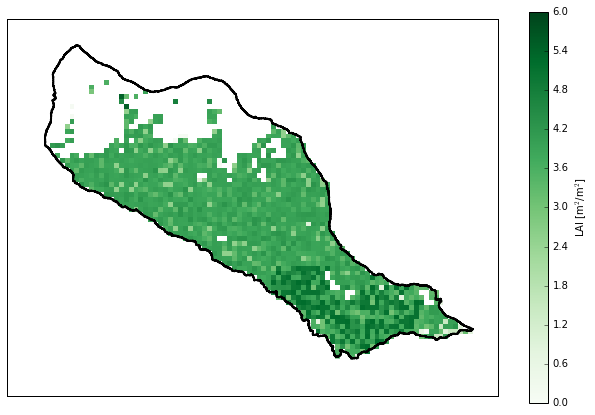

In [17]:
fig = plt.figure(figsize=(11,7))
m = Basemap(llcrnrlon=-105.588055,llcrnrlat=40.028710,urcrnrlon=-105.537108,
            urcrnrlat=40.057246,resolution=None,projection='merc',
            lon_0=coord2dd(105,33,45.03),lat_0=coord2dd(40,2,4.58))
mp = m.imshow(np.flipud(lai),cmap='Greens',interpolation='none',vmin=cmin,vmax=cmax)
m.readshapefile(shp[0:-4],shp.split('/')[-1].split('.')[0], color='k', linewidth=2);
plt.xlim(-500,6000)
plt.ylim(-500,4500)
fig.colorbar(mp,label = 'LAI [m$^2$/m$^2$]')
#plt.colorbar(label='m$^2$/m$^2$')
#plt.title('Como Creek Year %s'%int(year), fontsize=16)
ax = plt.gca()
ttl = ax.text(.5, 1.05, '', transform = ax.transAxes, va='center', fontsize=16)

In [18]:
def init():
    mp.set_data(np.flipud(lai))
    ttl.set_text('')
    return mp,ttl

In [19]:
def animate(i):
    year = ((i+1) * 10.)-10.

    rastpth = './data/LANDIS_output/climate_change/watershed/PGW_less_P/BDA+FIRE_+4C_minus15precip_1/TotalBiomass-%s_como.tiff'%(int(year))

    #print i
    #print year
    #print rastpth
    
    # change the model year to the actual year
    year -= 10
    year += offset

    ds=gdal.Open(rastpth)
    rast=np.array(ds.GetRasterBand(1).ReadAsArray(),dtype=float)
    
    
    lai = biomass2LAI(rast,sla,leaf_stem)
    lai[(mask==1) & (lai==0)] = 1.
    lai[np.isnan(mask)] = np.NaN
    
    mp.set_data(np.flipud(lai))
    ttl.set_text('Como Creek Year %s'%int(year))
    
    return mp,ttl,

In [20]:
anim = animation.FuncAnimation(fig,animate,init_func=init,
                               frames=12, interval=1000, blit=True)
anim.save('./figures/Como_LAI_PGW_LP_1990_2100.mp4', fps=5,dpi=200)